# Прогнозирование температуры звезды

![The color of Stars](https://sciencenotes.org/wp-content/uploads/2022/04/The-Colors-of-Stars-From-Hottest-to-Coldest.png)

Источник [sciencenotes.org](https://sciencenotes.org/the-colors-of-the-stars-from-hottest-to-coldest/)

## Введение

Цветовая классификация звезд https://sciencenotes.org/the-colors-of-the-stars-from-hottest-to-coldest/

Закзачик — обсерватория «Небо на ладони» — хочет перейти на технологии машинного обучения для определения температуры поверхности звезд. 

Для поиска решения на основе нейронных сетей заказчик предоставил харасктеристики и значения температуры 240 звезд. Характеристики данных следующие:
1. Относительная светимость $L/L_o$ — светимость звезды относительно Солнца.
1. Относительный радиус $R/R_o$ — радиус звезды относительно радиуса Солнца.
1. Абсолютная звёздная величина $M_v$ — физическая величина, характеризующая блеск звезды.
1. Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
1. Тип звезды:
    - 0 — Коричневый карлик
    - 1 — Красный карлик
    - 2 — Белый карлик
    - 3 — Звёзды главной последовательности
    - 4 — Сверхгигант
    - 5 — Гипергигант
1. Абсолютная температура $T(K)$ — температура на поверхности звезды в Кельвинах. 

Заказчик ожидает, что разработанная модель будет иметь RMSE не более 4500.

Заказчик просит включит в отчет график «Факт — Прогноз», где по горизонтальной оси будут отложены условные номера звёзд, а по вертикальной — температура в Кельвинах.

### Цель проекта

Целью проекта является разработка архитектуры и обучение модели, предсказывающей температуру поверхности звезды. 

Качество модели оценивается метрикой среднеквадратичная ошибка (RMSE) и должно быть меньше или равно 4500.

### Основные этапы

В проекты выполнены следующие основные этапы:
- исследовательский анализ данных,
- подготовка данных, включающая масштабирование числовых признаков , OHE кодирование категориальных, сокращение размерности методом PCA,
- разработка базовой модели,
- улучшение модели.

### Выводы

После подбора гиперпараметров мы получили обученную модель, которая на тестовой выборке имеет метрику RMSE 3120, что удовлетворяет условию заказчка меньше или равно 4500.

При решении задачи мы выполнили исследовательский анализ данных, выявили и исправили ошибки в данных, сократили размерность входных параметров для устранения мультиколлинеарности. 

Отметим, что размер данных для обучения составляет 240 объектов, среди которых распределение звезд по цвету неравномерно. В этих условиях на качество модели сильно влияет случайность при разбиение данных на обучающую/валидицаонную/тестовую. 

Врианты повышения стабильности результатов в данном случае: сократить области применения модели для цвета звезд (одна модель для красных звезд, другая для голубых и бело-голубых; по остальным цветам собрать больше даных) либо сделать апсемплинг методом SMOTENC. Предлагаем проверить эти гипотезы в следующем проекте по задаче прогнозирования температуры звезд.


## Подготовка кода

### Загрузка библиотек

In [1]:
from os import path
from functools import partial
from math import ceil
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [4]:
import torch
import torch.nn as nn

/Volumes/T7/working/yp14-torch-nn-refression/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import os

### Инициализация

#### Константы

In [6]:
RANDOM_STATE = np.random.RandomState(257515) 
torch.manual_seed(257515)
torch.use_deterministic_algorithms(True)

#### Иницализация трекинга

В работе над проектом мы использовали сервис [neptune.ai](https://neptune.ai) для трекинга экспериментов. Сейчас этот сервис отключен. Если понадобится подключить снова, нужно создать ключи проекта и API и указать их в файле .env, или заменить инициализацию констант непосредственно значениями ниже. 

In [7]:
USE_NEPTUNE = False

In [8]:
if USE_NEPTUNE:
    from dotenv import load_dotenv
    import neptune.new as neptune
    
    load_dotenv()
    PROJECT = os.getenv("PROJECT")
    API_TOKEN = os.getenv("API_TOKEN")
else: 
    neptune = None

### Функции и классы

#### normalize_color_values

In [9]:
def normalize_color_values(color: str) -> str:
    """Приводит значение цвета к форме: нижний регистр через пробел без"""
    
    return " ".join([_.strip() for _ in color.lower().replace("-", " ").split()])

#### reduce_color_values

In [10]:
def reduce_color_values(reduction_dict: dict, color: str) -> str:
    """Заменяет значение цвета на значение из словаря, либо возвращает исходное значение"""
    
    return reduction_dict[color] if color in reduction_dict else color

#### calc_vif

Основано на решении [steven](https://stackoverflow.com/a/54857466) @ stackoverflow, рассчитывает фактор инфляции дисперсии $ \mathit{VIF} = \frac{1}{1 - R^2}$ и толерантность $T = 1 - R$

In [11]:
def calc_vif(exogs: list, data: pd.DataFrame) -> pd.DataFrame:
    """Рассчитывает фактор инфляции дисперсии и толерантность для признаков exogs"""

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1 / (1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

#### make_run

In [12]:
def make_run(params: dict):
    """Creates Neptune Run"""
    
    if USE_NEPTUNE == False:
        return None
    
    run = neptune.init_run(
        project=PROJECT,
        api_token=API_TOKEN,
    )
    run["parameters"] = params
    return run

#### run_experiment

In [13]:
def run_experiment(_model):
    """Trains model with logging to Neptune"""
    run = make_run(_model.params)
    _model.fit(X_train_t, y_train_t, X_valid_t, y_valid_t, run)
    if run is not None:
        run.stop()  
    return _model

#### StarNet

Абстрактный базовый класс. Архитектура создается методом `_create_architecture`, который должен быть определен в производных классах.

In [14]:
class StarNet(nn.Module):
    def __init__(self,
                 n_in_neurons,
                 hidden_neurons,
                 n_out_neurons,
                 params,
                 verbose=True):
        super().__init__()

        assert params.get(
            "batch_size") is not None, "Missing batch_size in params"
        assert params.get(
            "learning_rate") is not None, "Missing learning_rate in params"
        assert params.get("n_epochs") is not None, "Missing n_epochs in params"

        self.params = params.copy()
        self.verbose = verbose
        self.rmse_min = np.Inf
        self.best_epoch = None

        # add params for logging
        self.params["n_neurons_in_layers"] = [
            n_in_neurons
        ] + hidden_neurons + [n_out_neurons]
        self.params["dims"] = n_in_neurons

        if params.get("model_name") is None:
            self.params["model_name"] = "StarNet"

        self._create_architecture(n_in_neurons, hidden_neurons, n_out_neurons)

        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=self.params["learning_rate"])

    def _create_architecture(self, n_in_neurons, hidden_neurons,
                             n_out_neurons):
        assert False, "This is an abstract method, have to be redefined in a subclass"

    def forward(self, X):
        """Does forward run"""
        out = X
        for c in self.children():
            if not isinstance(c, nn.MSELoss):
                out = c(out)
        return out

    def fit(self, X_train, y_train, X_valid, y_valid, run=None):
        """Trains model on train data and validates on valid"""

        batch_size = self.params.get("batch_size")
        n_epochs = self.params.get("n_epochs")
        n_batches = ceil(len(X_train) / batch_size)
        step = n_epochs // 10

        for epoch in range(n_epochs):
            order = np.random.permutation(X_train.size()[0])
            for butch_idx in range(n_batches):
                start_idx = butch_idx * batch_size
                butch_idxs = order[start_idx:start_idx + batch_size]
                X_butch = X_train[butch_idxs]
                y_butch = y_train[butch_idxs]

                self.train()
                self.optimizer.zero_grad()
                preds = self.forward(X_butch)
                loss_value = self.loss(preds.flatten(), y_butch.flatten())
                loss_value.backward()
                self.optimizer.step()

            # epoch's results
            self.eval()
            preds_valid = self.forward(X_valid)
            valid_loss_value = self.loss(preds_valid.flatten(),
                                         y_valid.flatten())
            self.rmse_score = np.sqrt(valid_loss_value.detach().numpy())
            if self.rmse_score < self.rmse_min:
                self.rmse_min = self.rmse_score
                self.best_epoch = epoch

            if run is not None:
                run["train/loss"].log(loss_value)
                run["train/rmse"].log(np.sqrt(loss_value.detach().numpy()))
                run["evaluation/loss"].log(valid_loss_value)
                run["evaluation/rmse"].log(self.rmse_score)

            if self.verbose and (epoch % step == 0 or epoch == n_epochs - 1):
                print(
                    f"Epoch {epoch:5d} Loss train {loss_value:,.0f}\tvalid {valid_loss_value:,.0f}"
                )
        if self.verbose:
            print(f"""
Valid RMSE: min {self.rmse_min:,.0f}
            last {self.rmse_score:,.0f}
            best epoch {self.best_epoch:,.0f}
""")

    def predict(self, X):
        """Does predictions """
        self.eval()
        return self.forward(X)

#### StarNetWDO

Производный класс с архитектурой: один скрытый слой, дропаут после входного слоя.

In [15]:
class StarNetWDO(StarNet):
    def __init__(self, n_in_neurons, hidden_neurons, n_out_neurons, params, verbose=True):
        super().__init__(n_in_neurons, hidden_neurons, n_out_neurons, params, verbose)
        if params.get("model_name") is None:
            self.params["model_name"] = "StarNetWDO"

    def _create_architecture(self, n_in_neurons, hidden_neurons,
                             n_out_neurons):
        assert len(
            hidden_neurons
        ) == 2, f"Expect 2 elements in hidden_neurons but {len(hidden_neurons)} was given"
        
        dropout_proba = .0 if "dropout_proba" not in self.params else self.params["dropout_proba"]
        
        # layers
        self.fc1 = nn.Linear(n_in_neurons, hidden_neurons[0])
        self.af1 = nn.ReLU()
        self.do1 = nn.Dropout(p=dropout_proba)
        self.fc2 = nn.Linear(hidden_neurons[0], hidden_neurons[1])
        self.af2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_neurons[1], n_out_neurons)

#### draw_fact_predictions

In [16]:
def draw_fact_predictions(facts, preds):
    plt.figure(figsize=(10, 5))
    x_axis = np.arange(preds.shape[0])
    plt.bar(x_axis, facts, .7, label="Факт", color="#9DE0EE")
    plt.bar(x_axis, preds, 0.35, label="Прогноз", color="#FDB50A")
    plt.title("Факт — Прогноз".upper(), fontsize="x-large")
    plt.ylabel("Температура звезды", fontweight="bold")
    plt.xlabel("Номер звезды в таблице данных", fontweight="bold")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.show()

## Загрузка данных

In [17]:
remote_path = 'https://code.s3.yandex.net/datasets/6_class.csv'
local_path = path.join('.', 'data', '6_class.csv')

if path.isfile(local_path):
    data = pd.read_csv(local_path, index_col=0)
else:
    data = pd.read_csv(remote_path, index_col=0)
    if path.exists(path.dirname(local_path)):
        data.to_csv(local_path)
        
data.shape

(240, 6)

Загружено 240 строк данных и 6 признаков.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


In [19]:
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


Состав признаков и их значения соответствуют информации в задаче. 

Приведем названия признаков к snake-case.

In [20]:
data.columns = [
    'temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type',
    'star_color'
]

### Разделение данных

Будем придреживаться принципа, согласно которому мы не должны видеть тестовые данные до этапа тестирования моделей. Поэтому выделим данные для теста до исследовательского анализа. Для теста оставим 10% даных.

In [21]:
X = data.drop('temperature', axis=1)
y = data.temperature
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.15,
                                                    random_state=RANDOM_STATE)

In [22]:
X_train.shape, y_train.shape

((204, 5), (204,))

In [23]:
X_test.shape, y_test.shape

((36, 5), (36,))

Размер выборок корректный.

Сравним статистики целевого признака для обучающей и тестовой выборок.

In [24]:
y_train.describe()

count      204.000000
mean      9866.779412
std       9269.668902
min       1939.000000
25%       3336.000000
50%       5046.000000
75%      13039.500000
max      40000.000000
Name: temperature, dtype: float64

In [25]:
y_test.describe()

count       36.000000
mean     14071.333333
std      10453.135125
min       2700.000000
25%       3536.500000
50%      14541.000000
75%      22767.500000
max      38234.000000
Name: temperature, dtype: float64

Статистики целевого признака на обучающей и тестовой выборке похожи. Разделение данных выполнено корректно.

### Вывод

Мы загрузили полученные данные. Состав признаков и количество объектов соответствуют указанным в задаче. 

Из данных мы выделили 15% объектов для тестирования результатов. 

Исследовательский анализ, обучение и настройку моделей будем проводить на обучающей выборки, из которой выделим валидационную.

## Исследовательский анализ данных

Сделаем датасет для анализа на основе обучающей выборки.

In [26]:
df = X_train.join(y_train).copy()

### Структура данных

В нашем датасете 240 объектов, 5 призаков и один целевой признак.

#### Типы данных признаков

In [27]:
df.dtypes

luminosity            float64
radius                float64
absolute_magnitude    float64
star_type               int64
star_color             object
temperature             int64
dtype: object

Целевой признак целочисленный, 3 признака имеют вещественный тип, один — целый и один — строковый. Целым и строковым типами представлены категориальные признаки.

Выделим названия целевого, численных и категориальных признаков.

In [28]:
target_column = ["temperature"]
numerical_columns = ["luminosity", "radius", "absolute_magnitude"]
categorical_columns = ["star_type", "star_color"]

#### Количество уникальных значений

In [29]:
df.nunique()

luminosity            181
radius                183
absolute_magnitude    197
star_type               6
star_color             19
temperature           194
dtype: int64

Все числовые признаки имеют сотни значений, то есть являются непрерывными.

#### Статистики числовых признаков

In [30]:
df[numerical_columns + target_column].describe()

,luminosity,radius,absolute_magnitude,temperature
count,204.000000,204.000000,204.000000,204.000000
mean,99012.591707,228.158643,4.732858,9866.779412
std,170184.883481,509.767354,10.532762,9269.668902
min,0.000080,0.008700,-11.920000,1939.000000
25%,0.000755,0.099525,-6.146000,3336.000000
50%,0.021500,0.672500,10.260000,5046.000000
75%,184000.000000,36.000000,13.990000,13039.500000
max,849420.000000,1948.500000,20.060000,40000.000000


Минимальное значение `luminosity` 0.00008, максимальное — 849420. Разница в 11 порядков. Медиана 0.02, среднее — 101994. 

У остальных признаков также видим большую разницу между максимумом и минимумом и смещение медианы от среднего. 

В нашем датасете очень разные звезды, как и во вселенной.

#### Вывод



Мы изучили структуру данных. Убедились, что данные соответсвуют описанным в задаче. 

Мы видим, что звезды в датасете очень сильно отличаются друг от друга по характеристам и распределение значений скошено.

### Качество данных

#### Дубликаты

In [31]:
duplicates_number = df.duplicated().sum()
print(f'Нашли {duplicates_number} дубликатов в датасете.')

Нашли 0 дубликатов в датасете.


#### Пропуски

In [32]:
df.isna().sum()

luminosity            0
radius                0
absolute_magnitude    0
star_type             0
star_color            0
temperature           0
dtype: int64

Пропусков тоже нет.

#### Паттерны и ошибки заполнения

Проверим наш датасет на проблемы с заполнением числовых значений.

Для каждого числового признака построим график, который визуализирует значения признака (ось Y) для каждого из объектов в датасете (ось X).

Мы ожидаем, что распределение значений будет охватывать весь диапазон по оси Y для всех объектов, то есть на всем протяжении оси X.

Пробелы по оси X покажут ошибки заполнения значений, а визуальные паттерны будут говорить о характере заполнения датасета.

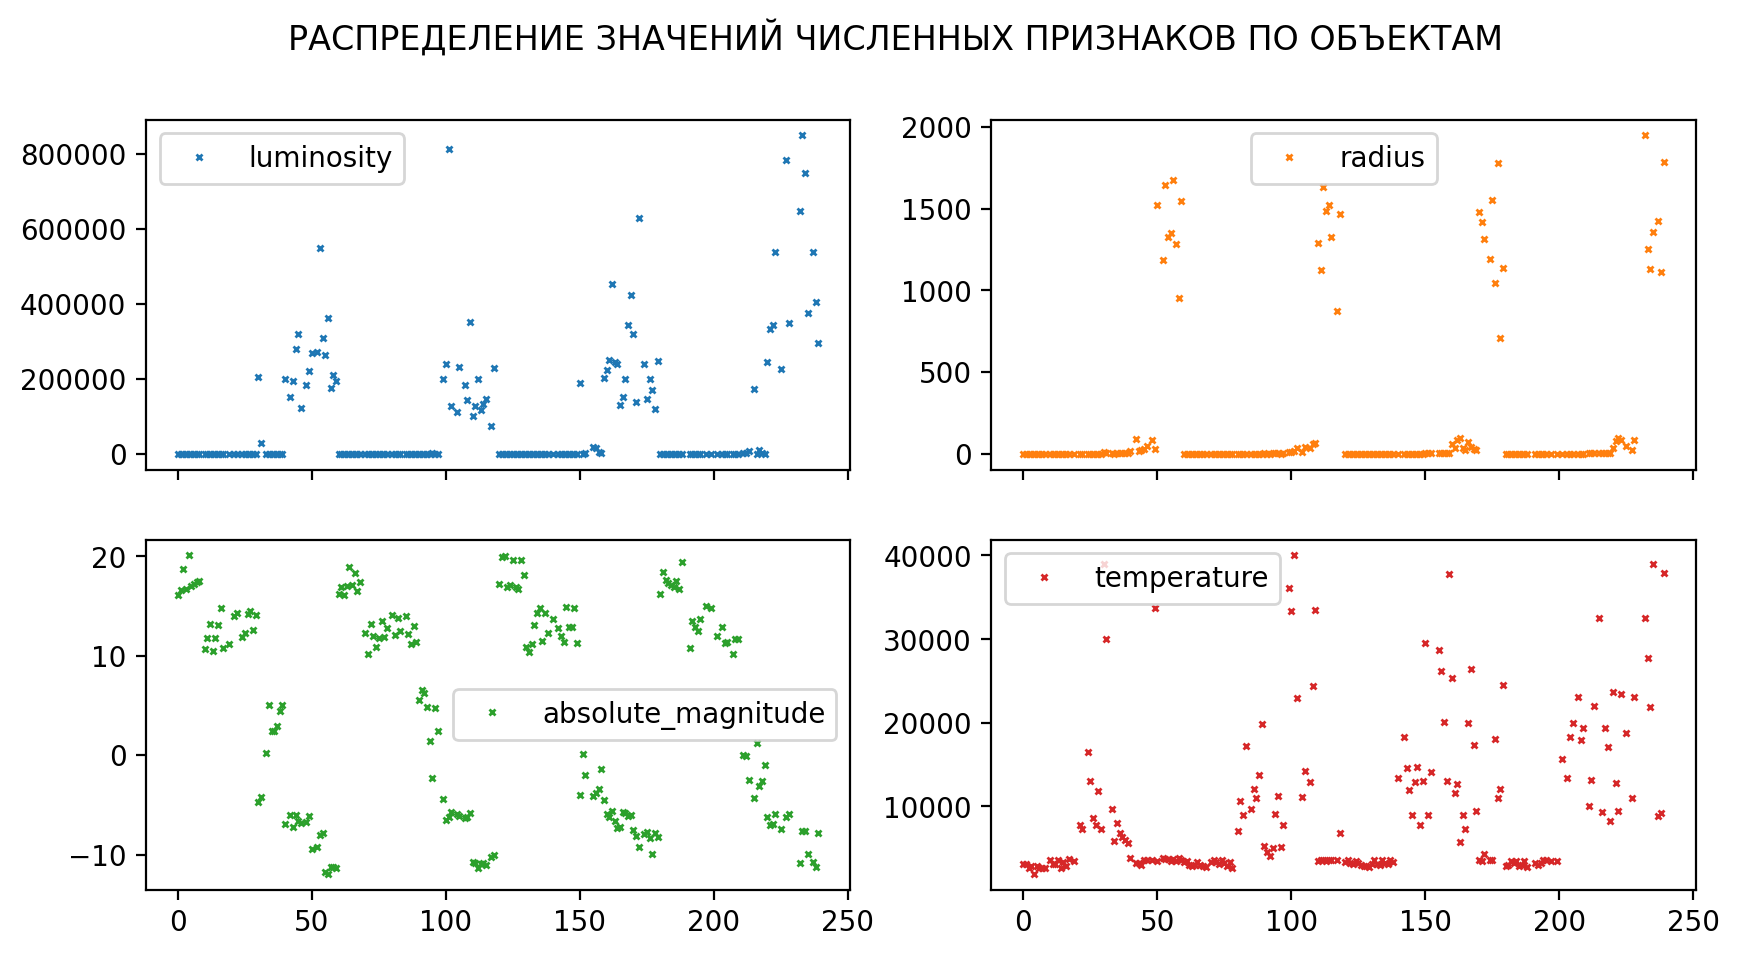

In [33]:
df[numerical_columns+target_column].plot(
    lw=0, marker="x", subplots=True, layout=(-1, 2),
    figsize=(10, 5), markersize=2, 
    title = 'Распределение значений численных признаков по объектам'.upper()
)
plt.legend(loc='upper left')
plt.show()

Мы видим, что датасет собран из 4 порций данных, в каждой из которых наблюдаем убвываение абсолютной зведной величины. 

Значения относительного радиуса группируются в два кластера: около нуля и 1000–2000.


Доля звезд с небольшой отсносительной светимостью и небольшим радиусом в датасете намного больше остальных. Мы наблюдаем дисбаланс данных.

Посмотрим на распределение объектов по категориям.

In [34]:
df.star_type.value_counts()

0    37
1    34
3    34
2    33
4    33
5    33
Name: star_type, dtype: int64

По типам звезд объекты распределены равномерно.

In [35]:
df.star_color.value_counts()

Red                   98
Blue                  42
Blue-white            20
Blue White             8
yellow-white           8
White                  6
Blue white             3
Yellowish White        3
white                  3
yellowish              2
Whitish                2
Orange                 2
Pale yellow orange     1
Orange-Red             1
Yellowish              1
Blue                   1
Blue white             1
Blue-White             1
White-Yellow           1
Name: star_color, dtype: int64

Тут мы видим большое количество дубликтов в названиях категорий. Оъекты распределены неравномерно.

#### Выводы

В данных нет дубликатов и пропусков. 

Значения признаков относительный радиус и относительная светимости имют большой разброс. Мы видим много объектов с маленькими значениями и несколько объектов с очень большими значениями.

В категориальном признаке цвет звезды мы видим неявные дубли в значениях.  

### Содержание данных

#### Анализ значений цвет звезды

Ранее мы видели, что в датасете 18 вариантов цвета звезд. [Современная спетральная классификации звезд](https://ru.wikipedia.org/wiki/Спектральная_классификация_звёзд) (Йеркская классификация или классификация Моргана — Кинана) по цвету имеет 7 классов (цветов)

|#|Класс|Температура (Кельвин, K)|Цвет|Показатель цвета B−V|Абсолютная звёздная величина $M_V$|
|---|---|---|---|---|---|
|1|O|> 30 000|Голубой|−0,3|−5,7…−3,3|
|2|B|10 000—30 000|Бело-голубой|−0,2|−4,1…+1,5|
|3|A|7400—10 000|Белый|0| +0,7…+3,1|
|4|F|6000—7400|Жёлто-белый| +0,4|+2,6…+4,6|
|5|G|5000—6000|Жёлтый| +0,6|+4,4…+6,0|
|6|K|3800—5000|Оранжевый| +1,0|+5,9…+9,0|
|7|M|2500—3800|Красный| +1,5|+9,0…+16|

В наших данных 18 униеальных значений цвета звезд. Изучим эти значения.

In [36]:
df.star_color = df.star_color.apply(normalize_color_values)
df.star_color.value_counts()

red                   98
blue                  43
blue white            33
white                  9
yellow white           8
yellowish white        3
yellowish              3
whitish                2
orange                 2
white yellow           1
pale yellow orange     1
orange red             1
Name: star_color, dtype: int64

Поскольку мы не знаем прицип присвоения значений цвета в нашем датасете, сверим распределение температур и звездных величин с классификацией.

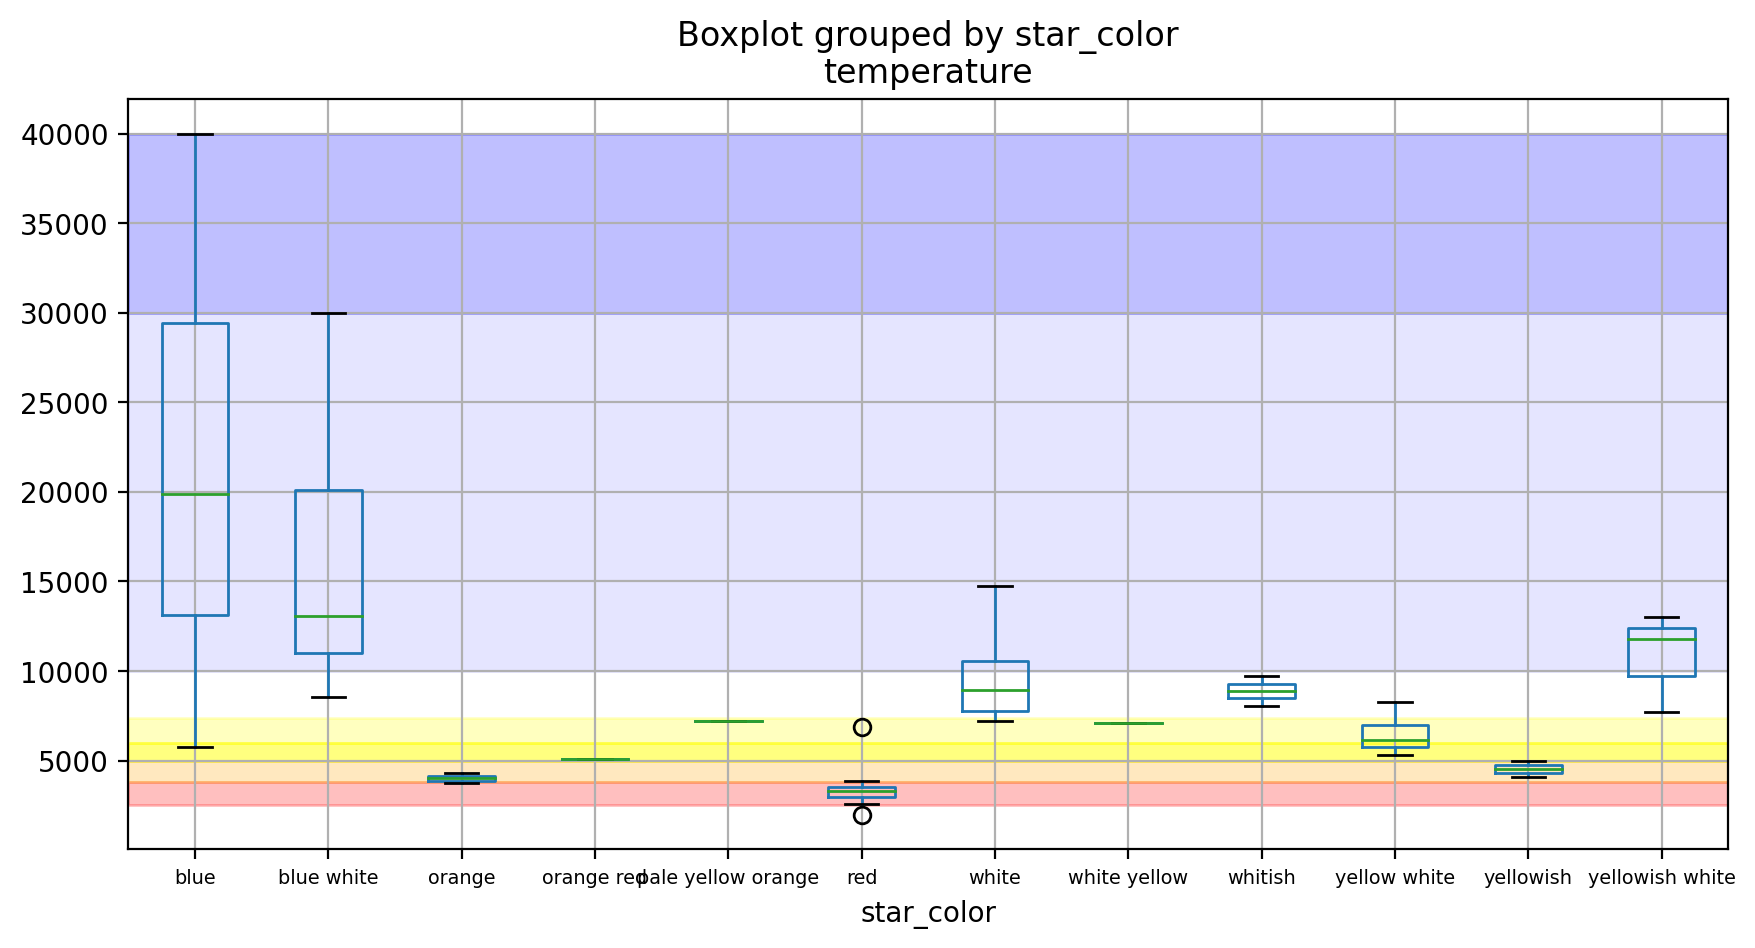

In [37]:
df.boxplot(column=["temperature"], by="star_color", figsize=(10,5))
plt.xticks(fontsize="x-small", rotation=0)
plt.axhspan(2500, 3800, color="red", alpha=.25)
plt.axhspan(3800, 5000, color="orange", alpha=.25)
plt.axhspan(5000, 6000, color="yellow", alpha=.5)
plt.axhspan(6000, 7400, color="yellow", alpha=.25)
plt.axhspan(7400, 10000, color="white", alpha=.1)
plt.axhspan(10000, 30000, color="blue", alpha=.1)
plt.axhspan(30000, 40000, color="blue", alpha=.25)
plt.show()

Мы видим, что некоторые цвета в нашем датасете не соответствуют Йеркской классификации: температура голубых звезд и "yellowish white" в нашем датасете попадает в диапозн темперетар бело-голубых звезд. 

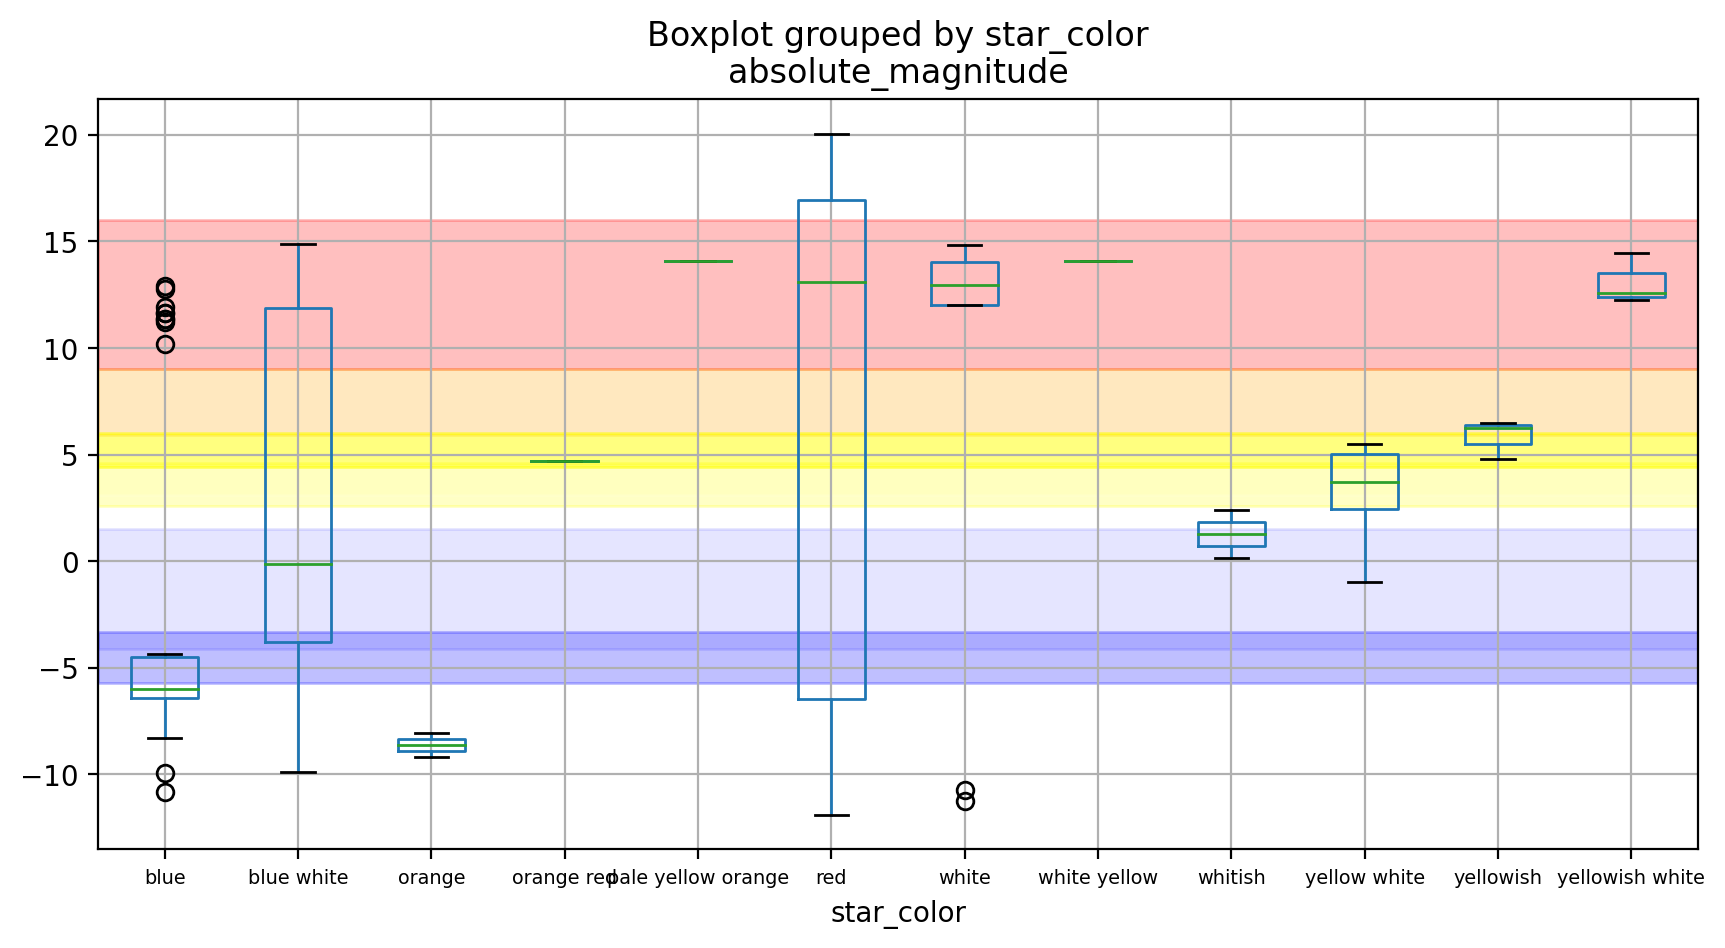

In [38]:
df.boxplot(column=["absolute_magnitude"], by="star_color", figsize=(10,5))
plt.xticks(fontsize="x-small", rotation=0)
plt.axhspan(9, 16, color="red", alpha=.25)
plt.axhspan(5.9, 9, color="orange", alpha=.25)
plt.axhspan(4.4, 6, color="yellow", alpha=.5)
plt.axhspan(2.6, 4.6, color="yellow", alpha=.25)
plt.axhspan(.7, 3.1, color="white", alpha=.1)
plt.axhspan(-4.1, 1.5, color="blue", alpha=.1)
plt.axhspan(-5.7, -3.3, color="blue", alpha=.25)
plt.show()

Тут мы видим, что по абсолютной зведной величине цвета в нашем датасете в большинстве случаев не совпадают с Йерской классификацией.

Значит мы не можем утвежрждать, что цвета отражают современную спекральную классификацию и не можем ориентироваться на нее. 

Сопоставим редкие значения цветов с часто встречающмися, опираясь на сходство по температуре.

In [39]:
reduce_color_values_dict = {
    "yellowish": "orange",
    "yellowish white": "yellow white",
    "pale yellow orange": "yellow white",
    "whitish": "white",
    "white yellow": "yellow white"
}
color_value_reduction_func = partial(reduce_color_values, reduce_color_values_dict)

Оценим количество объектов по значениям цвета после унификации значений.

In [40]:
df.star_color = df.star_color.apply(color_value_reduction_func)
df.star_color.value_counts()

red             98
blue            43
blue white      33
yellow white    13
white           11
orange           5
orange red       1
Name: star_color, dtype: int64

Мы сократили количество цветов до 6 значений. Объекты по-прежнему распределены неравномероно: количество белых и оранжевых звезд на порядок меньше количества красных и голубых.

#### Распределение значений

Оценим распределение значений для числовых признаков.

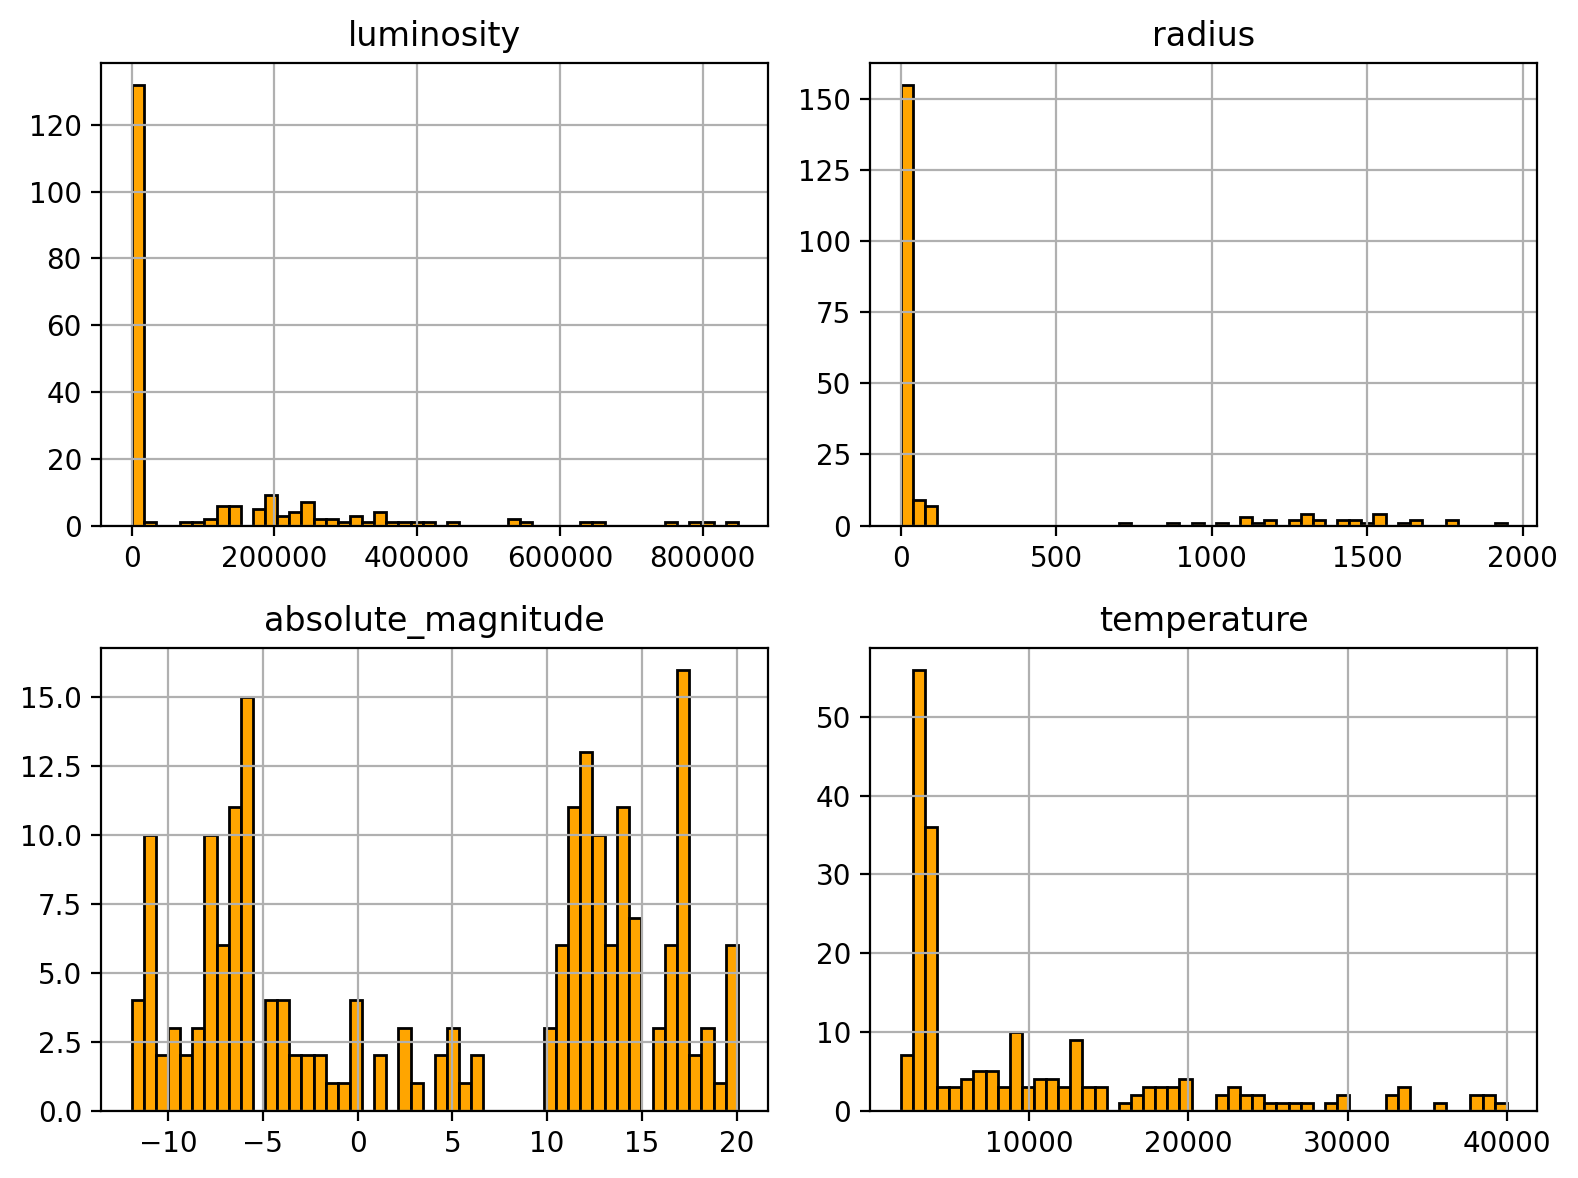

In [42]:
df[numerical_columns + target_column].hist(bins=50,
                                           figsize=(8, 6),
                                           layout=(-1, 2),
                                           color="orange",
                                           edgecolor="black")
plt.tight_layout()
plt.show()

Мы видим, что наш датасет состоит из подмножеств объектов с разными распределениями. Так, у относительных светимости и радиуса мы видим похожее на логнормальное распределение значений в районе нуля, и несколько групп значений с похожим на нормальное распределение: для светимости в раойне 200, 350 и 800 тыс, для радиуса в раоне 1300. 

Мы знаем, что звезды объединяют в классы по схожести признаков, и в наших данных несколько таких классов. Поэтому наблюдаемые распределения соответветсвтуют ожиданиям. 

#### Взаимосвязь признаков

Рассмотрим, как связаны между собой числовые признаки и числовые и категориальные.

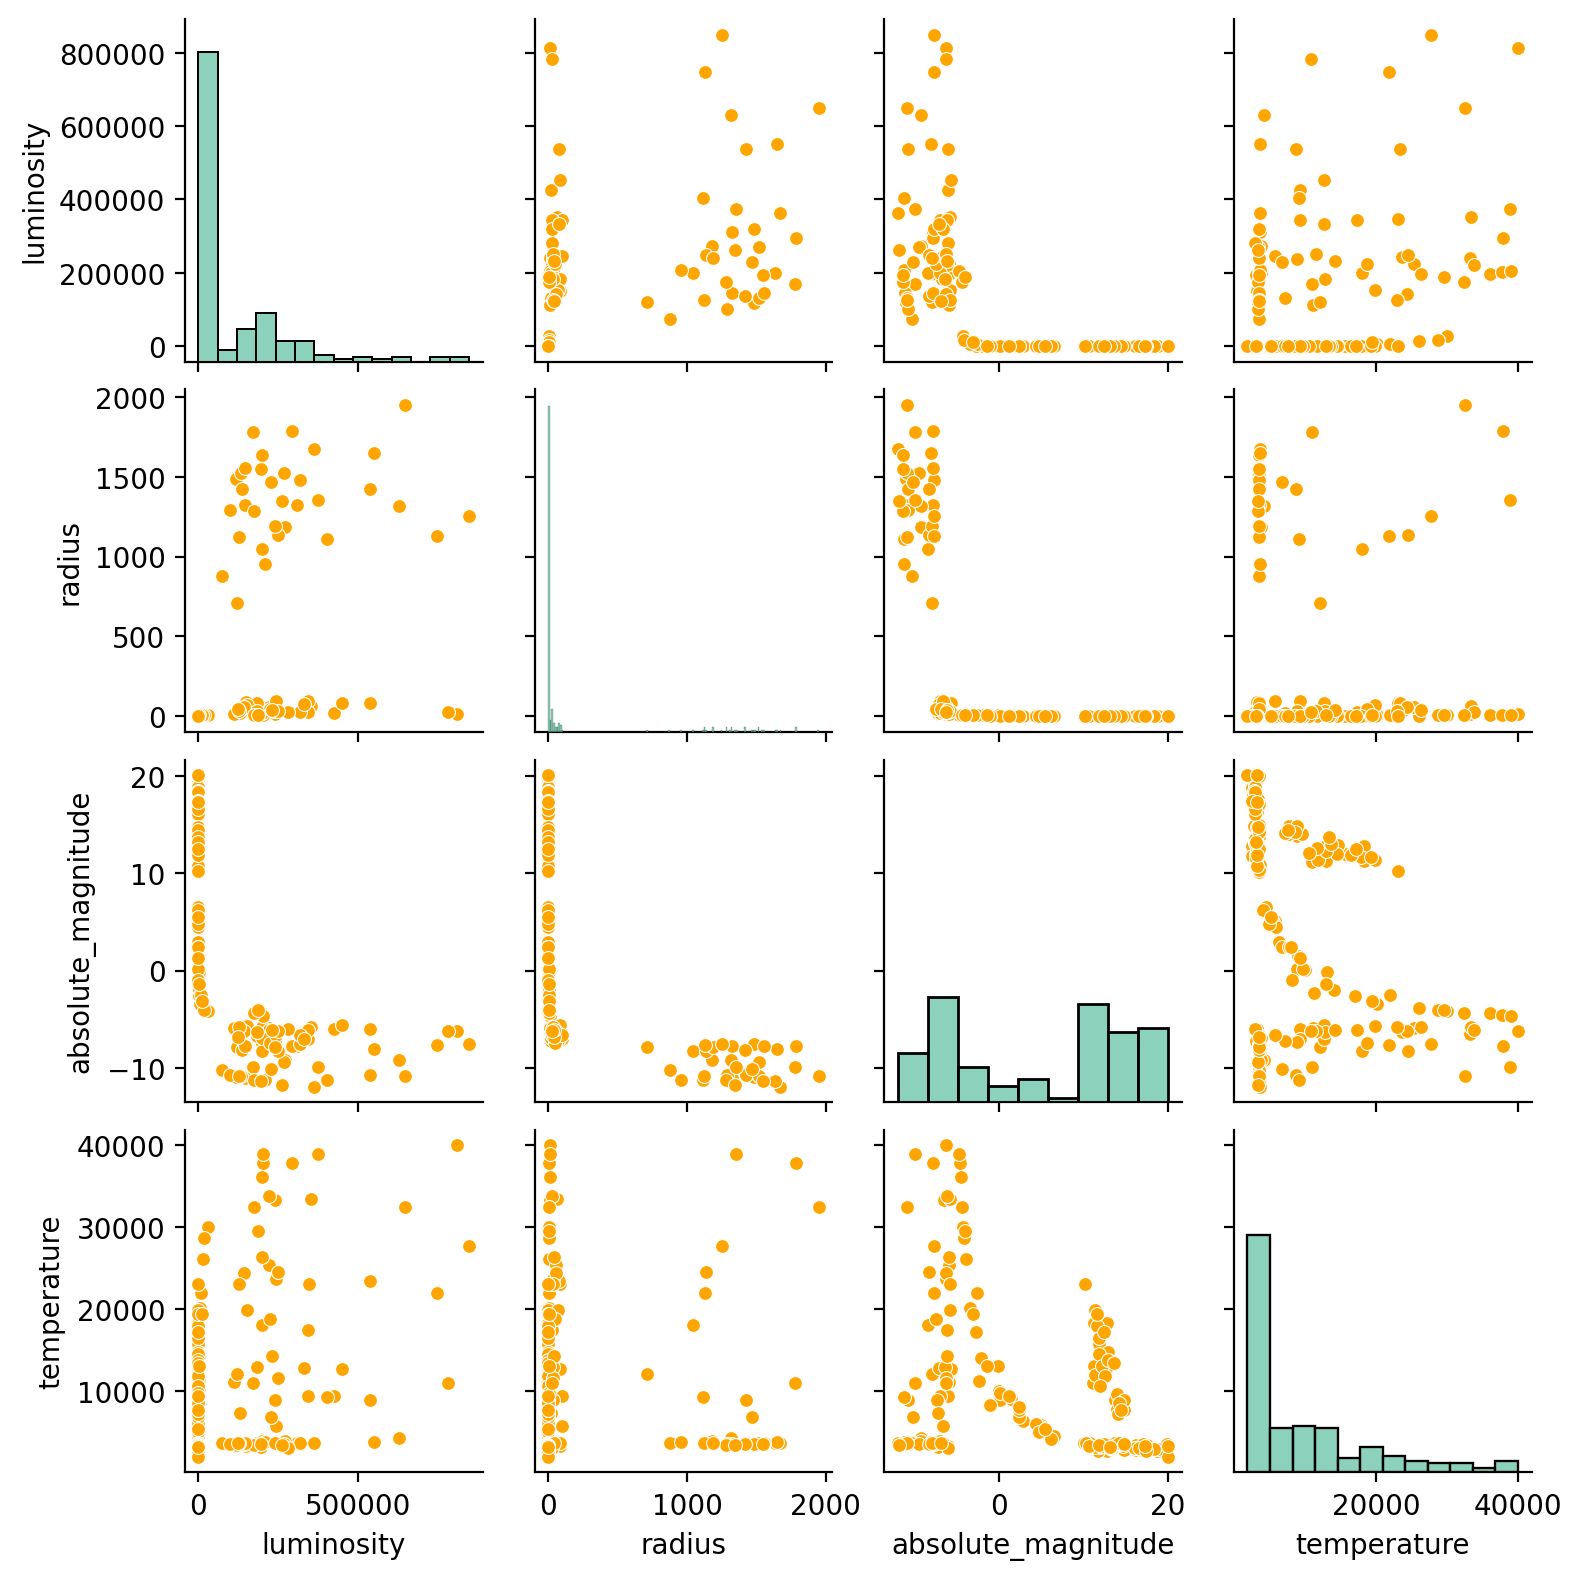

In [43]:
with sns.color_palette("Set2"):
    sns.pairplot(df[numerical_columns + target_column],
                 height=2,
                 plot_kws={
                     "s": 25,
                     "color": "orange"
                 })
plt.show()

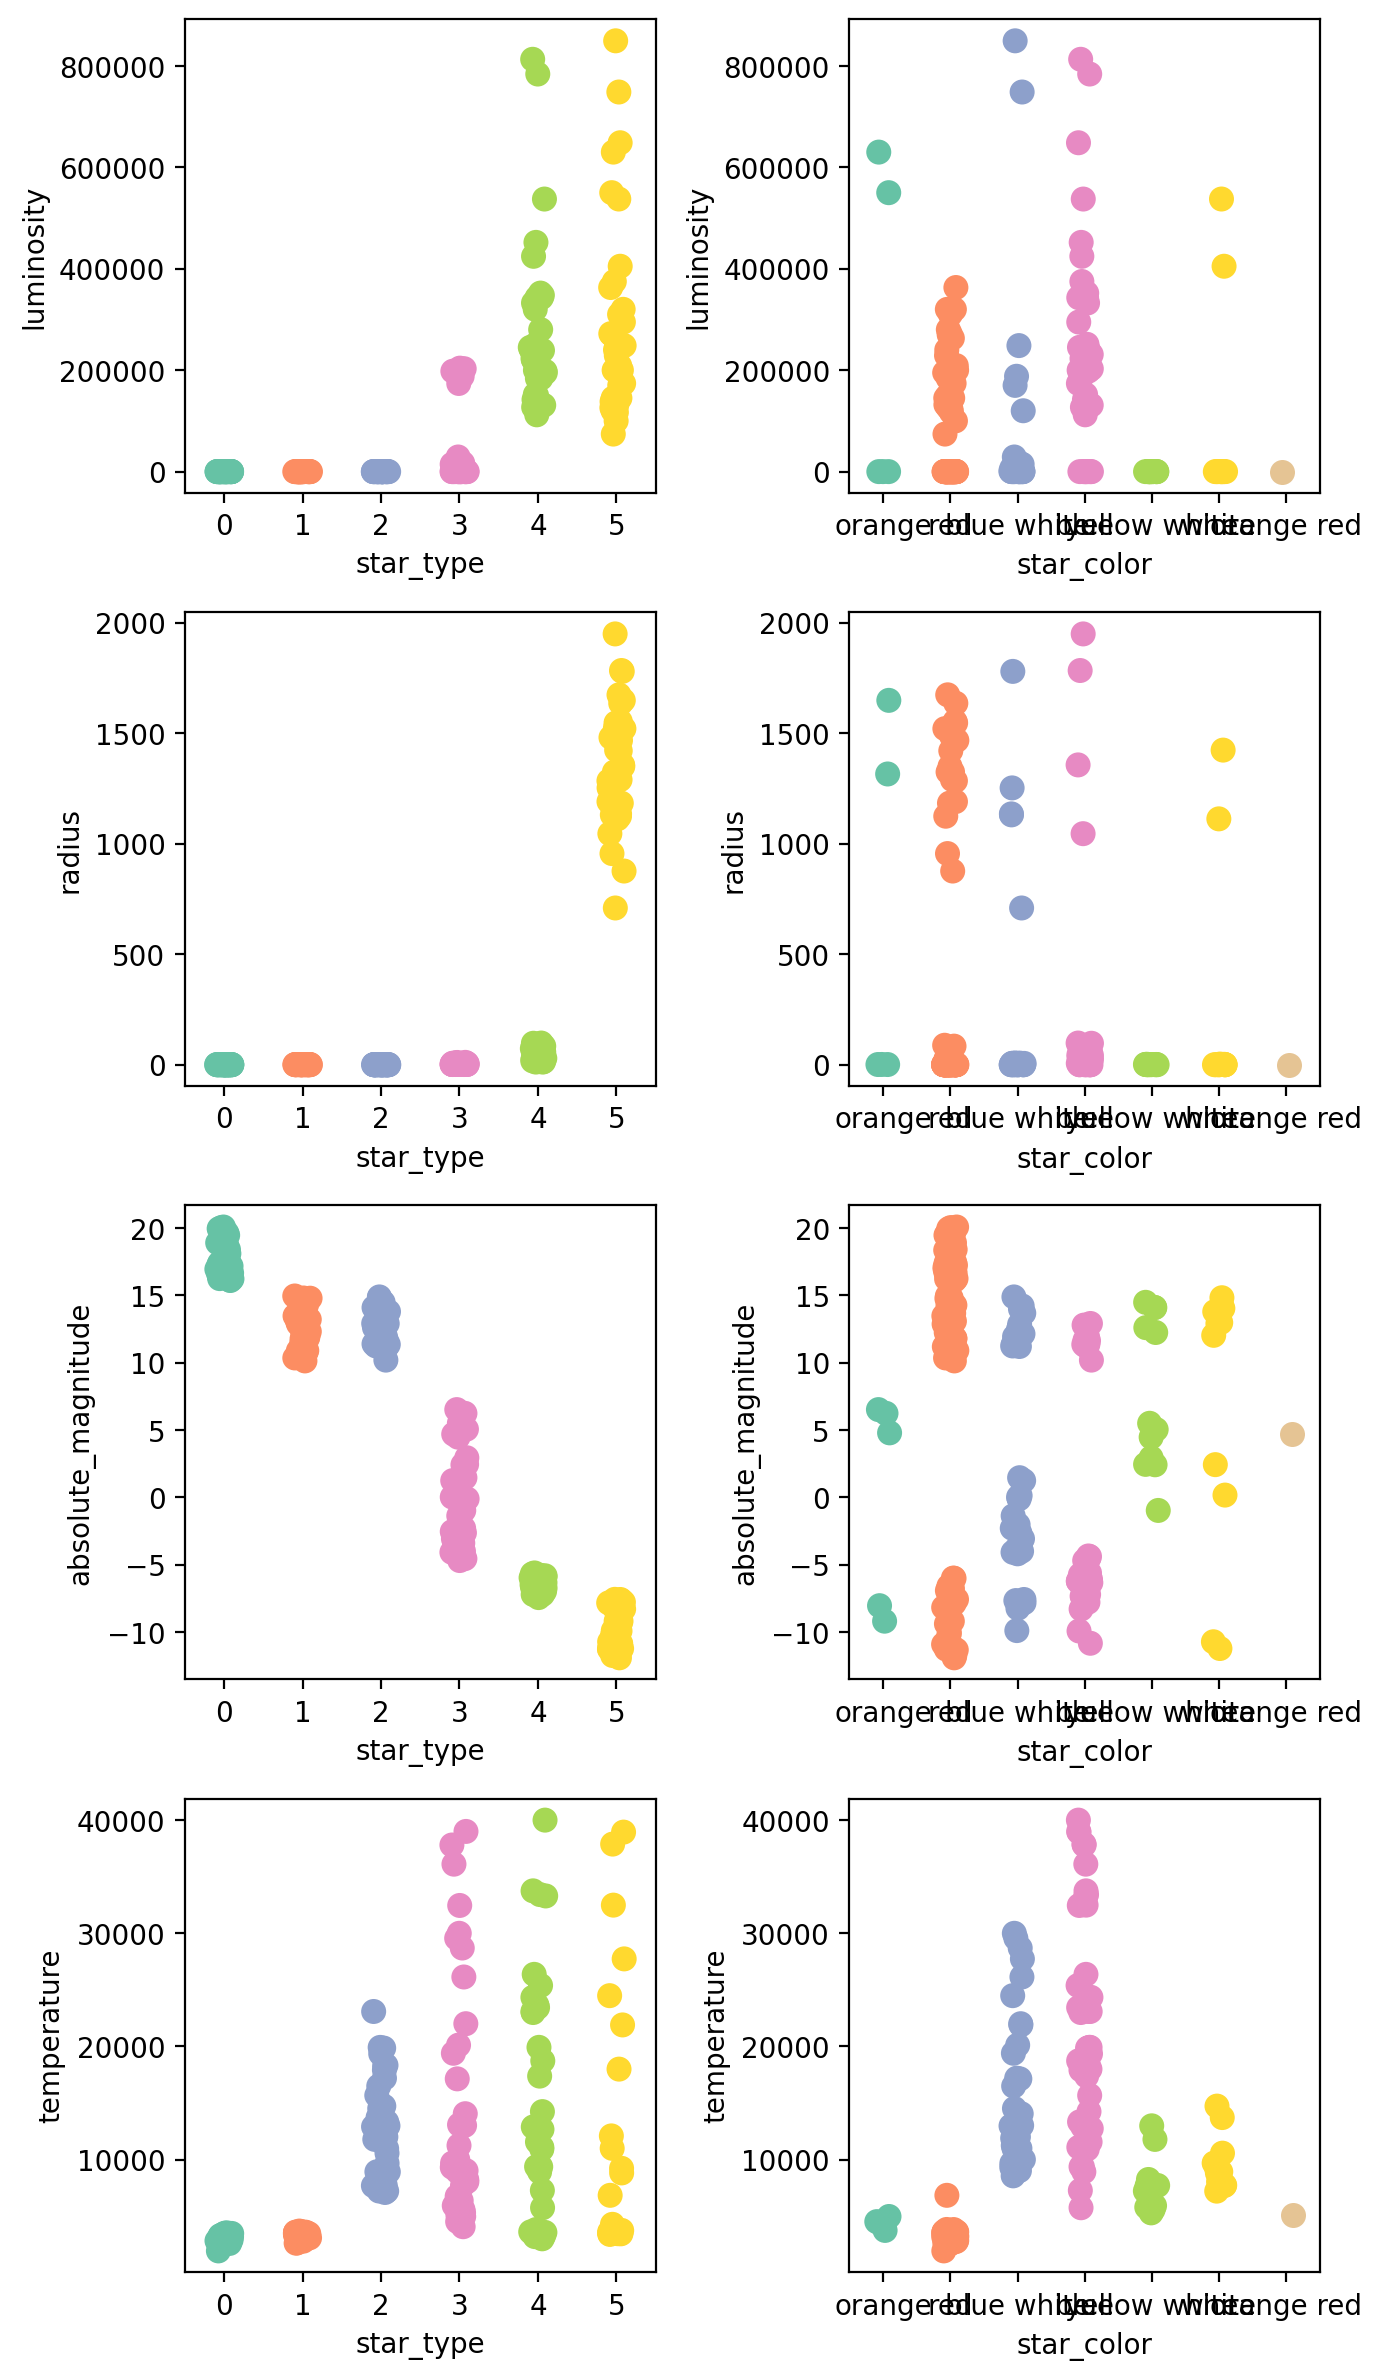

In [44]:
with sns.color_palette("Set2"):
    fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(7, 12))
    for j, category in enumerate(categorical_columns):
        for i, col in enumerate(numerical_columns+target_column):
            sns.stripplot(data=df,
                          x=category,
                          y=col,
                          ax=axes[i, j],
                          size=9)
plt.tight_layout()
plt.show()

Мы видим, что связи между признаками есть, но они в большинстве случаев носят нелинейный характер. Линейную связь вилим только между типом звезды и абсолютной звездной величиной. Еще видим степенную зависимость между абсолютной звездной величиной и температурой в середине диапазона значений $M_v$.

#### Анализ мультиколлинеарности

Поскольку мы видим связи между признаками, выполним анализ мультиколлинеарности признаков.

Закодируем категориальные признаки и подготовим датасет для анализа.

In [45]:
ohe_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
encoded = pd.DataFrame(ohe_encoder.fit_transform(df[categorical_columns]),
                       index=df.index)

encoded.columns = ohe_encoder.get_feature_names(categorical_columns)

encoded = (
    df
    # удалим целевой признак и категориальные признаки
    .drop(columns=target_column + categorical_columns)
    # присоединим закодированные признаки
    .join(encoded)
    # удалим первую закодированную категорию каждого признака
    .drop(columns=[encoded.columns[0], encoded.columns[len(ohe_encoder.categories_[0])]
    ]))

Рассчитаем фактор инфляции дисперсии $\mathit{VIF} = \frac{1}{1 - R^2}$ для признаков датасета. Значения больше 5 говорят о высокой мультиколлинеарности рассматриваемого признака с остальными признаками датасета.

In [46]:
encoded.head().T

,91,3,95,10,195
luminosity,0.153,0.0002,672.00,0.0029,0.0027
radius,0.865,0.1600,6.98,0.5100,0.6700
absolute_magnitude,6.506,16.6500,-2.30,10.6900,13.6670
star_type_1,0.000,0.0000,0.00,1.0000,1.0000
star_type_2,0.000,0.0000,0.00,0.0000,0.0000
star_type_3,1.000,0.0000,1.00,0.0000,0.0000
star_type_4,0.000,0.0000,0.00,0.0000,0.0000
star_type_5,0.000,0.0000,0.00,0.0000,0.0000
star_color_blue white,0.000,0.0000,1.00,0.0000,0.0000
star_color_orange,1.000,0.0000,0.00,0.0000,0.0000


Расчитаем фактора инфляции дисперсии.

Перед анализом выполним преобразования данных: переведем `luminosity` и `radius` в логарифмическую шкалу, чтобы сократить разборос значений, а также выполним масштабирование всех числовых признаков.

In [47]:
encoded[["luminosity", "radius"]] = np.log10(encoded[["luminosity", "radius"]])
scaler = MinMaxScaler()
encoded[numerical_columns] = scaler.fit_transform(encoded[numerical_columns])

In [48]:
vif = calc_vif(exogs=encoded.columns, data=encoded)
vif[vif.VIF>5].VIF

luminosity             65.804153
radius                111.452125
absolute_magnitude     82.172351
star_type_2            13.698488
star_type_3            30.221785
star_type_4            46.740669
star_type_5            87.278255
Name: VIF, dtype: float64

У семи признаков значение фактора инфляции дисперсии больше 10. Такой результат — следствие их мультиколлинеарности относительно остальных признаков нашего набора.

Изучим зависимость доли дисперсии, объясняемой признаками, при изменении размерности данных. Так мы сможем сократить количество признаков и избежать влияния мультиколиеарности.

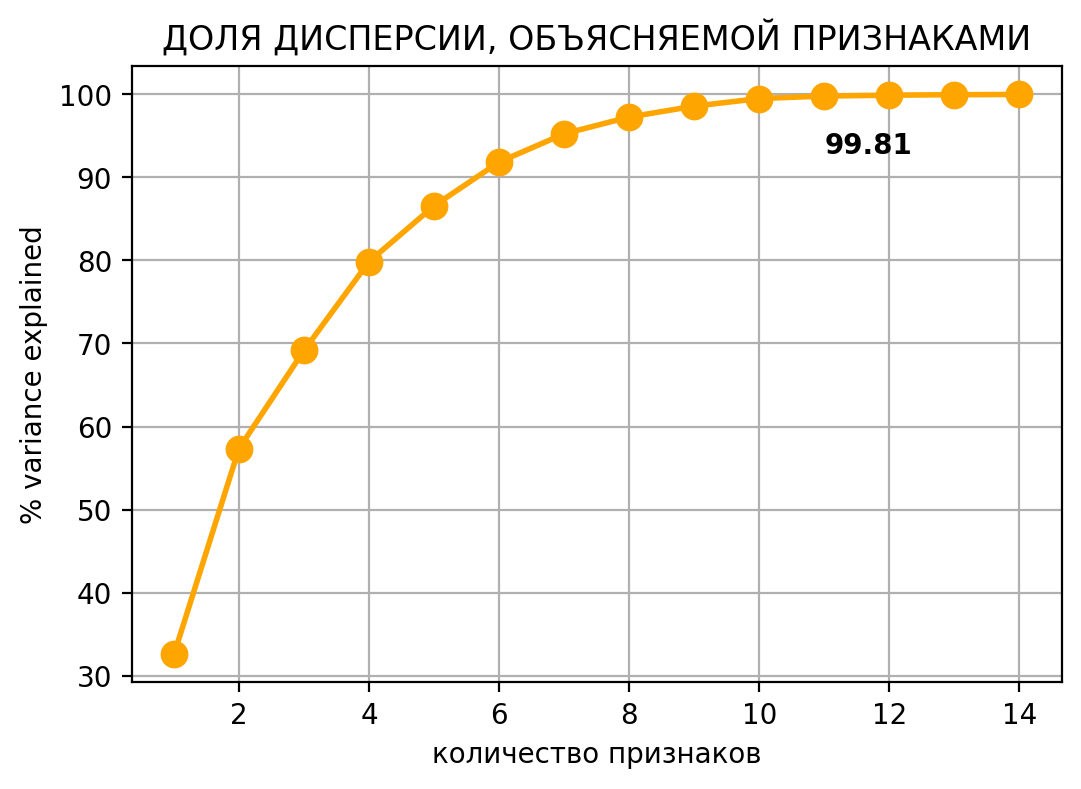

In [49]:
pca = PCA(n_components=encoded.shape[1])
pca_data = pca.fit_transform(encoded)

percent_var_explained = pca.explained_variance_ / (np.sum(
    pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.figure(figsize=(6, 4))
plt.plot(range(1, encoded.shape[1] + 1),
         cumm_var_explained * 100,
         markersize=9,
         marker="o",
         lw=2,
         color="orange")
plt.text(11, cumm_var_explained[10]*100 - 7, f"{cumm_var_explained[10]*100:.2f}", fontweight="bold")
plt.grid()
plt.title("Доля дисперсии, объясняемой признаками".upper())
plt.xlabel("количество признаков")
plt.ylabel("% variance explained")
plt.show()

Мы видим, что 99.91% дисперсии объясняется первыми 11-ю главными компонентами. Тогда при подготовке данных уменьшим разменость до 11.

### Выводы

Сруктура и содержание данных соответствуют описанию в задаче, пропусков и дубликатов в данных нет.

В данных три численных непрерывных признака и два категориальных.

Значения численных признаков имеют большой диапазон, возможно надо перевести эти признаки в логарифмическую шкалу. 

Значения цвета в датасете представлены 18 значениями, среди которых есть скрытые дубли из-за разного регистра и использования либо дефиса, либо пробела. Также используются разные варианты описания цвета. Мы разработали функции сокращения количества значений за счет удаления неявных дубликатов `normalize_color_values` и объединили редкие значения в более крупные группы, ориентируясь на значения температуры для цветов. Функция для сокращения значений, использующая словарь соответствий, —`color_value_reduction_func`.

Анализируя взаимосвязи признаков, мы выявили шесть признаков со значением фактора инфляции дисперсии больше 5. Анализ главных компонент показывает, что 98.79% дисперсии объясняется 9-ю главными компонентами.

## Подготовка данных

### Сокращение количества значений признака цвет звезды

In [50]:
X_train.star_color = X_train.star_color.apply(normalize_color_values)
X_train.star_color = X_train.star_color.apply(color_value_reduction_func)

/Volumes/T7/working/yp14-torch-nn-refression/venv/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [51]:
X_test.star_color = X_test.star_color.apply(normalize_color_values)
X_test.star_color = X_test.star_color.apply(color_value_reduction_func)

In [52]:
X_train.star_color.nunique()

7

Значения унифицированы.

### Кодирование категориальных признаков

In [53]:
ohe_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
ohe_encoder.fit(X_train[categorical_columns])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [54]:
encoded_columns = ohe_encoder.get_feature_names(categorical_columns)

X_train = (
    X_train
    .drop(columns=categorical_columns)
    .join(pd.DataFrame(ohe_encoder.transform(X_train[categorical_columns]),
                       index=X_train.index, 
                       columns=encoded_columns))
    .drop(columns=[encoded_columns[0], encoded_columns[len(ohe_encoder.categories_[0])]
    ]))

X_test = (
    X_test
    .drop(columns=categorical_columns)
    .join(pd.DataFrame(ohe_encoder.transform(X_test[categorical_columns]),
                       index=X_test.index, 
                       columns=encoded_columns))
    .drop(columns=[encoded_columns[0], encoded_columns[len(ohe_encoder.categories_[0])]
    ]))

X_train.shape, X_test.shape

((204, 14), (36, 14))

In [55]:
X_train.head().T

,91,3,95,10,195
luminosity,0.153,0.0002,672.00,0.0029,0.0027
radius,0.865,0.1600,6.98,0.5100,0.6700
absolute_magnitude,6.506,16.6500,-2.30,10.6900,13.6670
star_type_1,0.000,0.0000,0.00,1.0000,1.0000
star_type_2,0.000,0.0000,0.00,0.0000,0.0000
star_type_3,1.000,0.0000,1.00,0.0000,0.0000
star_type_4,0.000,0.0000,0.00,0.0000,0.0000
star_type_5,0.000,0.0000,0.00,0.0000,0.0000
star_color_blue white,0.000,0.0000,1.00,0.0000,0.0000
star_color_orange,1.000,0.0000,0.00,0.0000,0.0000


Признаки закодированы.

### Масштабирование числовых признаков

Переведем значения относительной светимости и радиуса в логарифмическую шкалу.

In [56]:
X_train[["luminosity", "radius"]] = np.log10(X_train[["luminosity", "radius"]])
X_test[["luminosity", "radius"]] = np.log10(X_test[["luminosity", "radius"]])

In [57]:
scaler = MinMaxScaler()
scaler.fit(X_train[numerical_columns])

MinMaxScaler()

In [58]:
X_train[numerical_columns] = scaler.transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
X_train[numerical_columns].describe()

,luminosity,radius,absolute_magnitude
count,204.000000,204.000000,204.000000
mean,0.464503,0.434886,0.520727
std,0.393801,0.315940,0.329355
min,0.000000,0.000000,0.000000
25%,0.097230,0.197827,0.180550
50%,0.242292,0.352917,0.693558
75%,0.933742,0.676011,0.810194
max,1.000000,1.000000,1.000000


Масштабирование сделано.

In [59]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 91 to 118
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   luminosity               204 non-null    float64
 1   radius                   204 non-null    float64
 2   absolute_magnitude       204 non-null    float64
 3   star_type_1              204 non-null    float64
 4   star_type_2              204 non-null    float64
 5   star_type_3              204 non-null    float64
 6   star_type_4              204 non-null    float64
 7   star_type_5              204 non-null    float64
 8   star_color_blue white    204 non-null    float64
 9   star_color_orange        204 non-null    float64
 10  star_color_orange red    204 non-null    float64
 11  star_color_red           204 non-null    float64
 12  star_color_white         204 non-null    float64
 13  star_color_yellow white  204 non-null    float64
dtypes: float64(14)
memory usa

In [60]:
X_train.head()

,luminosity,radius,absolute_magnitude,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue white,star_color_orange,star_color_orange red,star_color_red,star_color_white,star_color_yellow white
91,0.327308,0.373351,0.576173,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.039691,0.236366,0.893371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
95,0.690630,0.542848,0.300813,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10,0.155526,0.330466,0.707004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
195,0.152431,0.352615,0.800094,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [61]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 236 to 106
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   luminosity               36 non-null     float64
 1   radius                   36 non-null     float64
 2   absolute_magnitude       36 non-null     float64
 3   star_type_1              36 non-null     float64
 4   star_type_2              36 non-null     float64
 5   star_type_3              36 non-null     float64
 6   star_type_4              36 non-null     float64
 7   star_type_5              36 non-null     float64
 8   star_color_blue white    36 non-null     float64
 9   star_color_orange        36 non-null     float64
 10  star_color_orange red    36 non-null     float64
 11  star_color_red           36 non-null     float64
 12  star_color_white         36 non-null     float64
 13  star_color_yellow white  36 non-null     float64
dtypes: float64(14)
memory usa

In [62]:
X_train.shape, y_train.shape

((204, 14), (204,))

In [63]:
X_test.shape, y_test.shape

((36, 14), (36,))

### Сокращение размерности

In [64]:
pca = PCA(n_components=11, random_state=RANDOM_STATE)

In [65]:
X_train = pca.fit_transform(X_train)

In [66]:
X_test = pca.transform(X_test)

### Вывод

Мы подготовили данные в соответствии с выялвенными на этапе анализа выводами: сократили количество значений признака цвет звезды, закодировали категориальные признаки методом OHE, перевели значения `luminosity` и `radius` в логарифмическую шаклу и выполнили масштабирование численных признаков.

## Построение baseline модели

### Разделение train, valid

Выделим из обучающего датасета валидационную выборку

In [67]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, 
    y_train.values, 
    test_size=0.2, 
    shuffle=True,
    random_state=RANDOM_STATE)

In [68]:
X_train.shape, y_train.shape

((163, 11), (163,))

In [69]:
X_test.shape, y_test.shape

((36, 11), (36,))

Преобразуем датасет в тензоры.

In [70]:
X_train_t = torch.FloatTensor(X_train)
X_valid_t = torch.FloatTensor(X_valid)
y_train_t = torch.FloatTensor(y_train)
y_valid_t = torch.FloatTensor(y_valid)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.FloatTensor(y_test.values)

In [71]:
X_train_t.size(), X_valid_t.size(), X_test_t.size()

(torch.Size([163, 11]), torch.Size([41, 11]), torch.Size([36, 11]))

### Dummy модель

Оценим значение RMSE для модели, предсказывающей среднюю температуру.

In [72]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
pred = dummy_regr.predict(X_valid)
print(f"""
Dummy MSE\t{mean_squared_error(pred, y_valid):,.0f} 
      RMSE\t{np.sqrt(mean_squared_error(pred, y_valid)):,.0f}
""")


Dummy MSE	66,980,605 
      RMSE	8,184



### Baseline Модель

В качестве базовой построим модель с одним скрытым слоем без регуляризации и без батчинга. Для этого создадим класс StarNetWDO с архитектурой сести. 

Количество входов сети равно количеству признаков. Количество входов скрытого слоя возьмем равным количеству входов сети, а количество выходов в два раза меньше. _Эти значения были подобраны в серии экспериментов с использованием сревиса [neptune.ai](https://neptune.ai)_

Выход у сети один для задачи регресии.

In [73]:
n_in_neurons = X_train_t.size()[1]
n_out_neurons = 1 

В качестве гиперпараметров возьмем следующие значения.

In [74]:
params = {
    "learning_rate": 0.01,
    "n_epochs": 4000,
    "batch_size": X_train_t.size()[0]
}

Запустим эксперимент. Если клиент neptune.ai инициализирован, результаты обучения будут отправлены в этот сервис. Здесь мы выведем результаты для 10 эпох и финальные результаты.

In [75]:
base_model = run_experiment(
    StarNetWDO(n_in_neurons=n_in_neurons,
            hidden_neurons=[n_in_neurons, n_in_neurons // 2],
            n_out_neurons=1,
            params=params))

Epoch     0 Loss train 187,087,424	valid 166,018,544
Epoch   400 Loss train 45,058,056	valid 23,381,764
Epoch   800 Loss train 29,242,180	valid 11,917,910
Epoch  1200 Loss train 25,476,992	valid 11,288,559
Epoch  1600 Loss train 23,053,378	valid 11,149,273
Epoch  2000 Loss train 21,491,180	valid 11,086,867
Epoch  2400 Loss train 20,760,602	valid 10,945,631
Epoch  2800 Loss train 20,059,480	valid 10,616,824
Epoch  3200 Loss train 18,996,074	valid 9,829,259
Epoch  3600 Loss train 18,253,752	valid 9,437,708
Epoch  3999 Loss train 17,803,790	valid 9,271,209

Valid RMSE: min 3,043
            last 3,045
            best epoch 3,971



Построим график План-Факт на тестовой выборке.

In [76]:
preds = base_model.predict(X_test_t).flatten().detach().numpy()
facts = y_test_t.flatten()

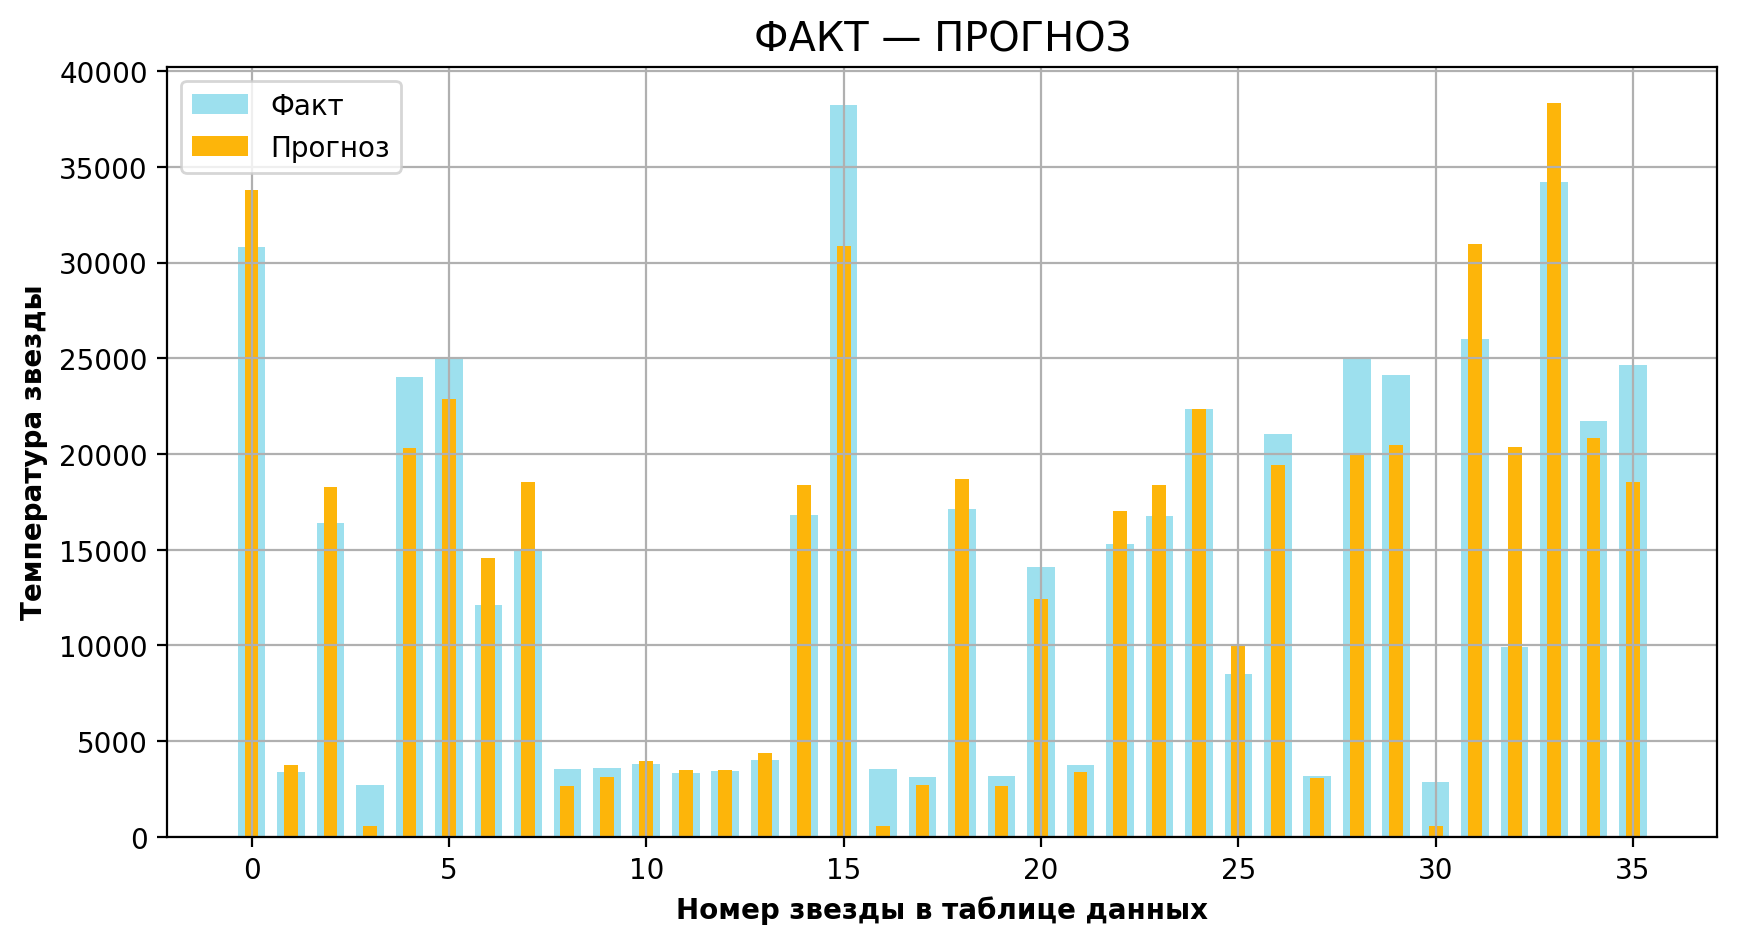

In [77]:
draw_fact_predictions(y_test_t.flatten(), preds)

#### Вывод

Мы получили значение RMSE, удовлетворяющее заданию и более чем в 2.5 раза лучше dummy-модели.

Отметим, что мы наблюдаем в обучении значения loss-функции на трейне больше, чем на валидации. Обычно мы видим противоположную картину. 

Объяснить такое поведение нашей модели мы можем очень маленьким набором данных для обучения и дисбалансом объектов по цвету и типу звезд. В таком случае на метрики начинает влиять случайность при разделении данных на обучающую/валидицаонную/тестовую. И если изменить значение RANDOM_SEED, можно на тех же исходных данных и том же коде получить существенно отличающиеся значения RMSE. 

Врианты повышения стабильности результатов в данном случае: сократить области применения модели для цвета звезд (одна модель для красных звезд, другая для голубых и бело-голубых; по остальным цветам собрать больше даных) либо сделать апсемплинг методом SMOTENC. Предлагаем проверить эти гипотезы в следующем проекте по задаче прогнозирования температуры звезд.

## Улучшение модели

Оценим влияние на точность модели гиперпараметров `dropout_proba` (вероятность выключения нейрона в слое) и `batch_size` (размер батча при обучении).

In [78]:
dropout_proba = np.linspace(0,.6,7)
batch_size = [ 21,  42, 84, 168]

Для каждой комбинации гиперпараметров создадим и обучим модель.

In [79]:
search_results = {
    "dropout_proba": [],
    "batch_size": [],
    "rmse_min": [],
    "rmse_last": [],
    "best_epoch": [],
    "model": [],
}

print("  DP   BS\tRMSE min\tRMSE last\tBest Epoch")
for dp in dropout_proba:
    params["dropout_proba"] = dp
    for bs in batch_size:
        params["batch_size"] = bs
        _m = StarNetWDO(n_in_neurons=n_in_neurons,
                        hidden_neurons=[n_in_neurons, n_in_neurons // 2],
                        n_out_neurons=1,
                        params=params,
                        verbose=False)
        _m.fit(X_train_t, y_train_t, X_valid_t, y_valid_t)
        print(f"{dp:.2f}  {bs:3d}\t{round(_m.rmse_min):4,d}\t\t{round(_m.rmse_score):4,d}\t\t{_m.best_epoch:4d}")
        search_results["dropout_proba"].append(dp)
        search_results["batch_size"].append(bs)
        search_results["rmse_min"].append(_m.rmse_min)
        search_results["rmse_last"].append(_m.rmse_score)
        search_results["best_epoch"].append(_m.best_epoch)
        search_results["model"].append(_m)   
print(f"      min\t{np.min(search_results['rmse_min']):,.0f}\t\t{np.min(search_results['rmse_last']):,.0f}")
print(f"   median\t{np.median(search_results['rmse_min']):,.0f}\t\t{np.median(search_results['rmse_last']):,.0f}")

  DP   BS	RMSE min	RMSE last	Best Epoch
0.00   21	2,919		3,203		1187
0.00   42	2,881		3,027		2350
0.00   84	2,962		2,984		3262
0.00  168	3,057		3,074		2958
0.10   21	2,953		3,178		2362
0.10   42	2,937		3,098		2152
0.10   84	2,977		3,024		3805
0.10  168	3,085		3,131		3920
0.20   21	2,943		3,176		2224
0.20   42	2,954		3,143		3226
0.20   84	3,142		3,147		3988
0.20  168	3,314		3,318		3968
0.30   21	2,982		3,070		3874
0.30   42	2,975		3,015		3601
0.30   84	2,998		3,114		3971
0.30  168	3,372		3,406		3871
0.40   21	3,323		4,670		 211
0.40   42	3,011		3,055		3983
0.40   84	3,105		3,128		3992
0.40  168	3,392		3,406		3980
0.50   21	3,362		5,504		 227
0.50   42	3,156		3,397		2307
0.50   84	3,074		3,099		3988
0.50  168	3,383		3,490		1130
0.60   21	3,415		3,513		3244
0.60   42	3,175		3,444		2316
0.60   84	3,305		3,357		3988
0.60  168	3,663		3,741		1509
      min	2,881		2,984
   median	3,080		3,162


Сделаем графический анализ влияния гиперпараметров на точность.

In [85]:
_sr = pd.DataFrame(search_results).query("rmse_last < 4500")

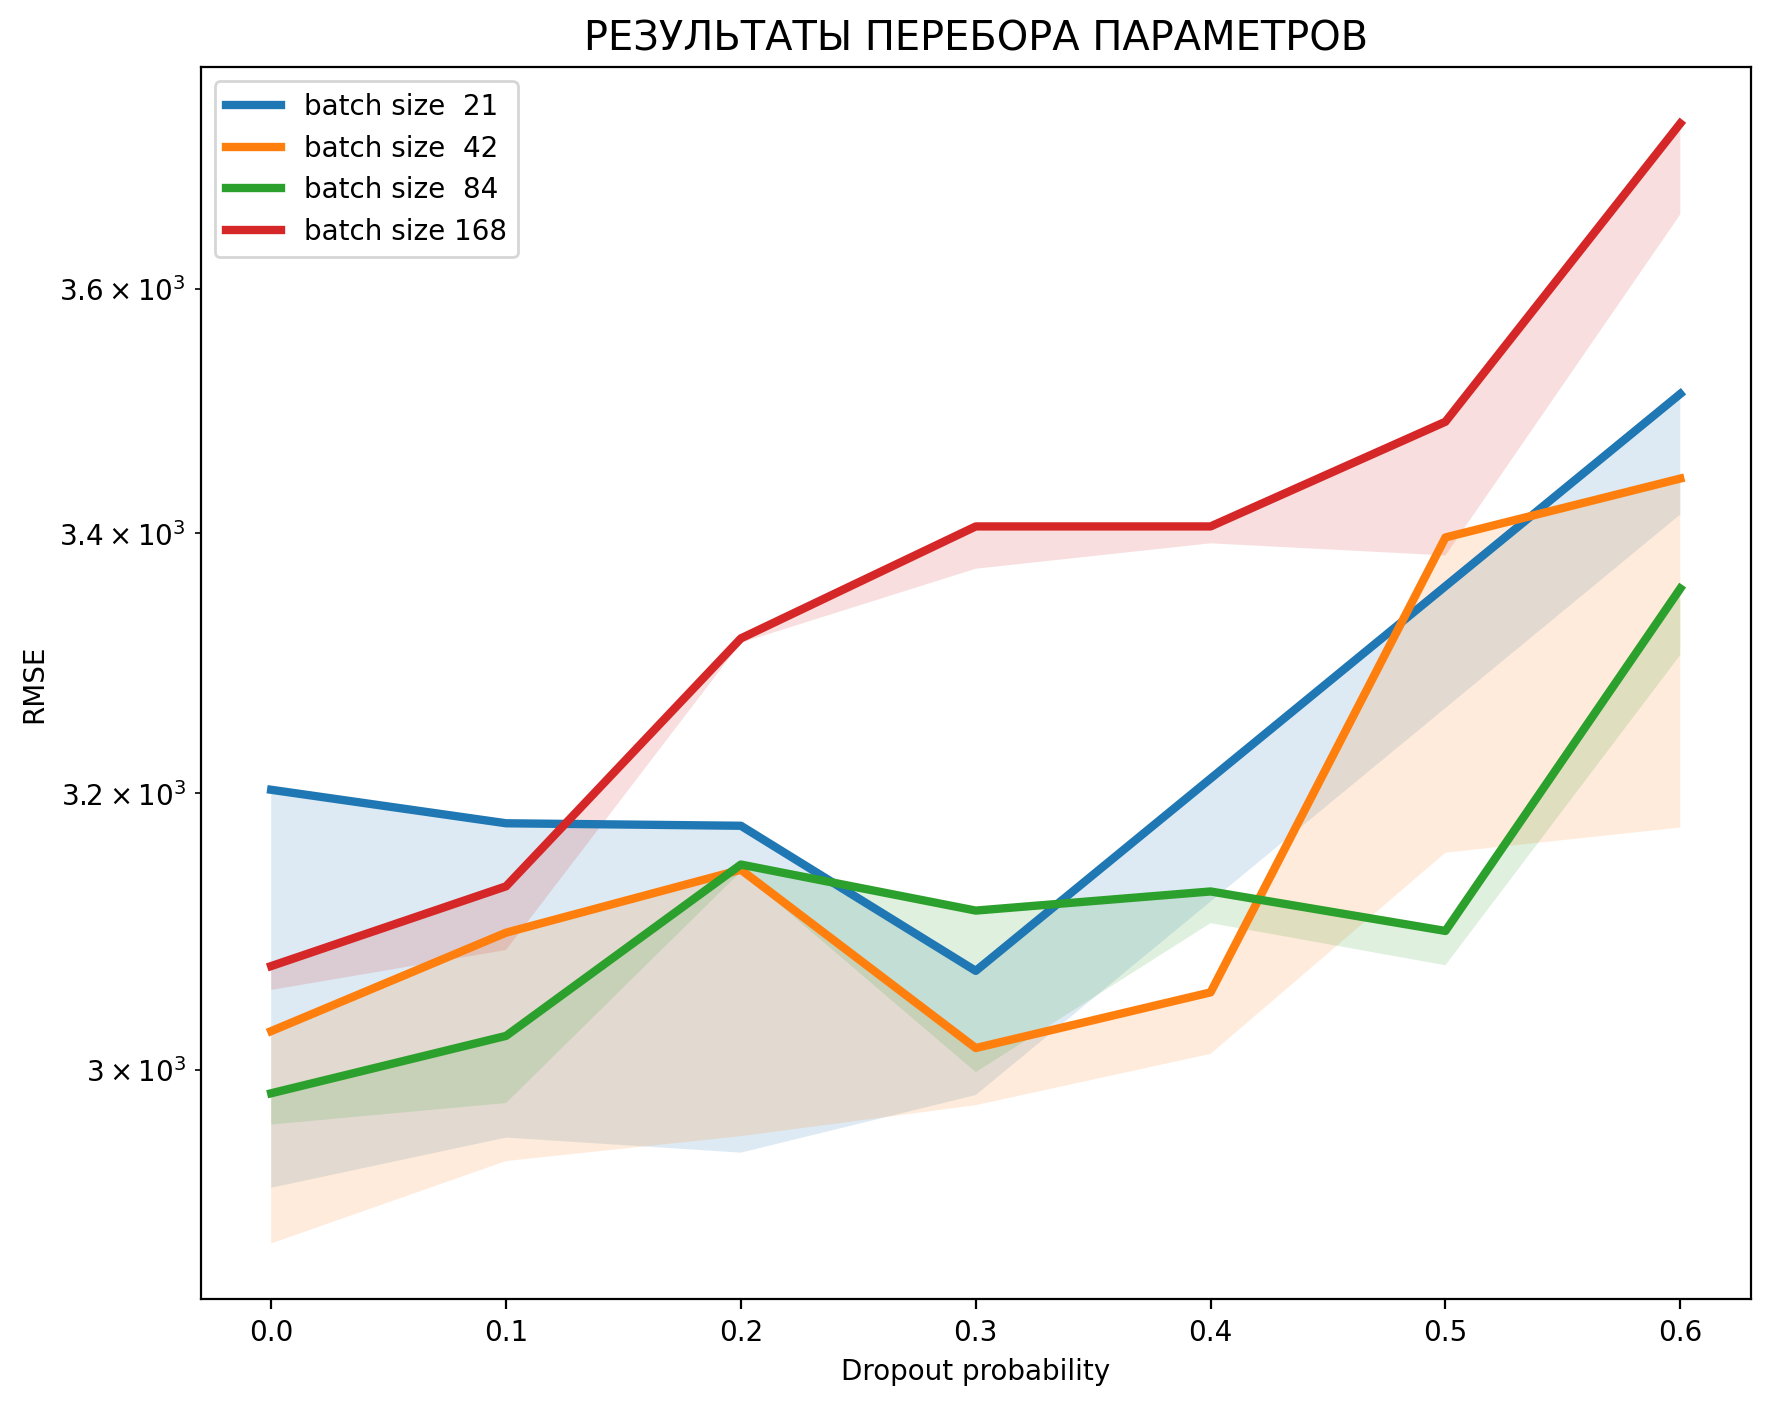

In [86]:
plt.figure(figsize=(10,8))
for bs in batch_size:
    _subset = _sr.query("batch_size == @bs")
    plt.plot(_subset.dropout_proba, _subset.rmse_last, lw=3, label=f"batch size {bs:3d}")
    plt.fill_between(_subset.dropout_proba, _subset.rmse_min, _subset.rmse_last, alpha=.15)
plt.yscale("log")
plt.legend(loc="upper left")
plt.title("Результаты перебора параметров".upper(), fontsize="x-large")
plt.ylabel("RMSE")
plt.xlabel("Dropout probability")
plt.show()

Базовая модель соответствует точке на красной линии при значении dropout probablity 0.

Мы видим, что без дропаута использование батчей размером 84 дает наилучший результат. 

Дропаут 0.1 немного улучшает результаты для батча 84 и сильно улучшает результат для обучения без батчей. Дальнейшее увеличение дропаута уже сказывается отрицательно. 

Мы видим, что в процессе обучения нам удается достигать большей точности, чем по окончанию обучения на всех заданных эпохах. Предлагаем как улучшение для следующего этапа проекта сохранять состояния модели в процессе обучения для наименьших значений loss-функции на валидационных данных и после завершения обучения использовать параметры модели, давшие наименьший loss.

### Вывод

Перебор параметров позволил нам улучшить точность модели. Три модели с наименьшим RMSE по итогам обучения следующие.

In [82]:
_sr.sort_values(by="rmse_last")[:3]

,dropout_proba,batch_size,rmse_min,rmse_last,best_epoch,model
2,0.0,84,2962.015869,2983.720703,3262,"StarNetWDO(\n (fc1): Linear(in_features=11, o..."
13,0.3,42,2975.461426,3015.379639,3601,"StarNetWDO(\n (fc1): Linear(in_features=11, o..."
6,0.1,84,2976.961426,3023.940430,3805,"StarNetWDO(\n (fc1): Linear(in_features=11, o..."


## Тестирование модели

Проверим точность лучших моделей на тестовых данных.

In [83]:
loss = nn.MSELoss()
best_model = None
best_preds = []
best_rmse = np.Inf

for (i, row) in _sr.sort_values(by="rmse_last")[:3].iterrows():
    preds = row.model.predict(X_test_t)
    rmse = np.sqrt(loss(preds.flatten(), y_test_t.flatten()).detach().numpy())
    print (f"{i:2d} RMSE {rmse:,.0f}")
    if rmse < best_rmse:
        best_model = row.model
        best_preds = preds.flatten().detach().numpy()
        best_rmse = rmse

print(f"\nBest test RMSE {best_rmse:,.0f} for model with" + 
      f" droupout_proba {best_model.params['dropout_proba']:0.2f}" +
      f" and batch_size {best_model.params['batch_size']}")
    

 2 RMSE 3,067
13 RMSE 3,238
 6 RMSE 3,147

Best test RMSE 3,067 for model with droupout_proba 0.00 and batch_size 84


Постром итоговоый факт-прогноз.

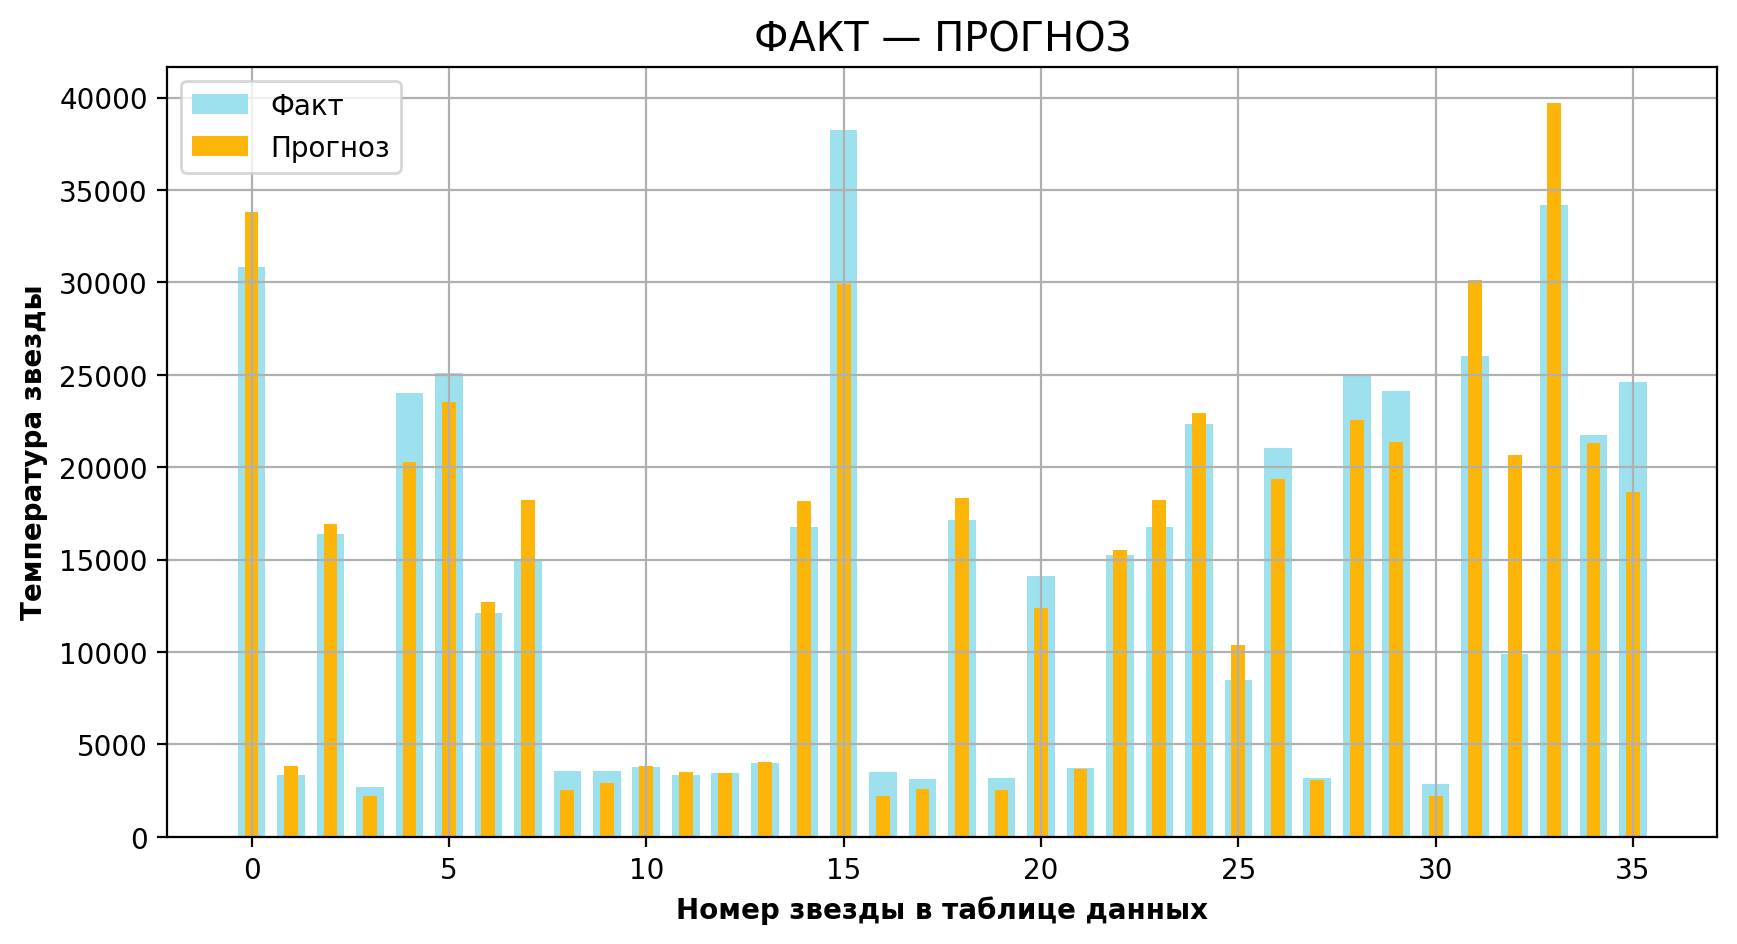

In [84]:
draw_fact_predictions(y_test_t.flatten(), best_preds)

## Выводы

Мы разработали архитектуру нейронной сети и обученили модели, предсказывающей температуру поверхности звезды. 

После подбора гиперпараметров мы получили обученную модель, которая на тестовой выборке имеет метрику RMSE 3120, что удовлетворяет условию заказчка меньше или равно 4500.

При решении задачи мы выполнили исследовательский анализ данных, выявили и исправили ошибки в данных, сократили размерность входных параметров для устранения мультиколлинеарности. 

Отметим, что размер данных для обучения составляет 240 объектов, среди которых распределение звезд по цвету и типу неравномерно. В этих условиях на качество модели сильно влияет случайность при разбиение данных на обучающую/валидицаонную/тестовую. 

Врианты повышения стабильности результатов в данном случае: сократить области применения модели для цвета звезд (одна модель для красных звезд, другая для голубых и бело-голубых; по остальным цветам собрать больше даных) либо сделать апсемплинг методом SMOTENC. Предлагаем проверить эти гипотезы в следующем проекте по задаче прогнозирования температуры звезд.
